This example is an MB-MVPA code that uses part of the data (Tom et al., 2007).<br>
Tom's full dataset used 16 subjects, but in this example, only 2 subjects are used to save resource.

### Import the MB-MVPA libarary.

Other libraries(nilean, keras, etc..) dosen't need to be imported.<br>
Because mb-mvpa has wrapping the libararies.<br>
You don't necessarily have to know fMRI libraries like nilearn and machine learning libraries like tensorflow.<br>
<b>MB-MVPA is all you need.</b>

Most of mb-mvpa are wrapping nilearn, tensorflow, Keras and etc., so warning can occur from that libraries.<br>
This page does not print warning because most of them are can be ignored.<br>
<b> You do not need to remove the warning when you are actually using it. </b>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from mbmvpa.preprocessing.bids import bids_preprocess
from mbmvpa.preprocessing.events import events_preprocess
from mbmvpa.data.loader import prepare_dataset
from mbmvpa.utils.example_utils import load_example_data

Data download from AWS S3, ~ 1GB.<br>
If you run this example more than once, the data will already be downloaded.<br>
If So, do not download it again.

In [2]:
root = load_example_data("tom")

data load success! (tom)


### Preprocessing bids data including fMRI images
The MB-MVPA liabrary need to BIDS format including preprocessed nii images*(nii or nii.gz)* and behavior data file*(.tsv)*.<br>
The fMRI images are usually located here<br>
**derivatives/fmriprep/**<br>
And the behavior data are located here<br>
**subject/session/run/func**

In [3]:
X, voxel_mask, layout = bids_preprocess(root, smoothing_fwhm=None, zoom=(2, 2, 2), ncore=2, nthread=4)

bids preprocessing done!                          :  83%|████████▎ | 5/6 [00:18<00:03,  3.13s/it]INFO:root:time elapsed: 0.31 minutes
INFO:root:masking data shape: (46, 55, 46)
bids preprocessing done!                          : 100%|██████████| 6/6 [00:18<00:00,  3.07s/it]


Our mbmvpa is directly inputted into the data and modulation functions to be used to increase user's freedom and increase stability.<br>
The following three functions must be completed, each of which means:<br>
1. If you use **hbayesDM**, you should change the columns name to suit it. -> preprocess
2. If you only want to use behavioral data under certain conditions, you must define a condition function. -> condition
3. Finally, since we are model-based fMRI, we have to calculate the modulation.<br>
   The important point is that the behavioral data that we already have are in the **"row"**, and parameters estimated by model are in the **"param_dict"**.<br>
   -> modulation

In [4]:
def example_tom_preprocess_columns(row):
    ## rename data in a row to the name which can match hbayesdm.ra_prospect requirements ##
    row["gamble"] = 1 if row["respcat"] == 1 else 0
    row["cert"] = 0
    return row

In [5]:
def example_tom_condition(row):
    # include all trial data
    return True

In [6]:
def example_tom_modulation(row, param_dict):
    ## calculate subjectives utility for choosing Gamble over Safe option
    ## prospect theory with loss aversion and risk aversion is adopted
    modulation = (row["gain"] ** param_dict["rho"]) - (param_dict["lambda"] * (row["loss"] ** param_dict["rho"]))
    row["modulation"] = modulation
    return row

If you have parameters already calculated and can provide them in *.tsv*, we also allow that.<br>
"**individual_params_custom"** has the role.<br>
In that case, the dm_model, or deicison making model, is not required.

In [7]:
dm_model, df_events, signals, time_masks, _ = \
    events_preprocess(root,
                      preprocess=example_tom_preprocess_columns,
                      condition=example_tom_condition,
                      modulation=example_tom_modulation,
                      dm_model="ra_prospect")

hbayesdm doing (model: ra_prospect)..                      :  50%|█████     | 3/6 [00:03<00:04,  1.61s/it]INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl



Model  = ra_prospect
Data   = <pandas.DataFrame object>

Details:
 # of chains                    = 4
 # of cores used                = 1
 # of MCMC samples (per chain)  = 4000
 # of burn-in samples           = 1000
 # of subjects                  = 2
 # of (max) trials per subject  = 256

Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl


calculating modulation..                          :  67%|██████▋   | 4/6 [11:21<03:25, 102.87s/it]         

Index(['onset', 'duration', 'parametric loss', 'distance from indifference',
       'parametric gain', 'gain', 'loss', 'ptval', 'respnum', 'respcat',
       'responsetime', 'subjid', 'run', 'gamble', 'cert'],
      dtype='object')
['onset', 'duration', 'parametric loss', 'distance from indifference', 'parametric gain', 'gain', 'loss', 'PTval', 'respnum', 'respcat', 'response_time', 'subjID', 'run', 'gamble', 'cert']
************************************
**** Model fitting is complete! ****
************************************
   subjID       rho    lambda        tau
0       1  0.513109  1.026472  14.224075
1       2  0.433893  1.603317  13.735144


events preproecssing done! 11.36 minutes                                    : 100%|██████████| 6/6 [11:21<00:00, 113.64s/it]


### Load data and shape check

Through the above process, **X(fMRI images)** and **Y(modulation)** dataset can be obtained.<br>
Their shape[0] is must be equal.

In [8]:
X, y, voxel_mask = prepare_dataset(root=layout.derivatives["fMRIPrep"].root)

In [9]:
X.shape, y.shape

((1440, 1977), (1440,))

### Fitting MVPA models & Results

In [10]:
from mbmvpa.utils.coef2map import get_map
import time

In [11]:
from mbmvpa.models.regressor import penalized_linear_regression

s = time.time()
coefs = penalized_linear_regression(X, y,
                                    layout,
                                    lambda_param=2.0,
                                    batch_size=256,
                                    N=30,
                                    verbose=1)

task_name = "tom2007_penalized_linear"
result = get_map(coefs, voxel_mask, task_name=task_name, map_type='z', save=True, save_path='./results', sigma=1)
e = time.time()
print(f"elapsed time: {(e-s) / 60:.2f} minutes")

INFO:root:start running
INFO:root:[1/30] - val_mse: 0.1576
INFO:root:[2/30] - val_mse: 0.1606
INFO:root:[3/30] - val_mse: 0.1670
INFO:root:[4/30] - val_mse: 0.1656
INFO:root:[5/30] - val_mse: 0.1708
INFO:root:[6/30] - val_mse: 0.1600
INFO:root:[7/30] - val_mse: 0.1618
INFO:root:[8/30] - val_mse: 0.1581
INFO:root:[9/30] - val_mse: 0.1546
INFO:root:[10/30] - val_mse: 0.1408
INFO:root:[11/30] - val_mse: 0.1510
INFO:root:[12/30] - val_mse: 0.1434
INFO:root:[13/30] - val_mse: 0.1605
INFO:root:[14/30] - val_mse: 0.1689
INFO:root:[15/30] - val_mse: 0.1599
INFO:root:[16/30] - val_mse: 0.1631
INFO:root:[17/30] - val_mse: 0.1567
INFO:root:[18/30] - val_mse: 0.1805
INFO:root:[19/30] - val_mse: 0.1628
INFO:root:[20/30] - val_mse: 0.1666
INFO:root:[21/30] - val_mse: 0.1772
INFO:root:[22/30] - val_mse: 0.1747
INFO:root:[23/30] - val_mse: 0.1674
INFO:root:[24/30] - val_mse: 0.1674
INFO:root:[25/30] - val_mse: 0.1538
INFO:root:[26/30] - val_mse: 0.1596
INFO:root:[27/30] - val_mse: 0.1695
INFO:root:[28

elapsed time: 4.10 minutes


In [12]:
from mbmvpa.models.regressor import mlp_regression

s = time.time()
coefs = mlp_regression(X, y,
                       layout,
                       layer_dims=[1024, 1024],
                       activation="linear",
                       dropout_rate=0.5,
                       epochs=100,
                       patience=10,
                       batch_size=64,
                       N=3,
                       verbose=1)

task_name = "tom2007_mlp"
result = get_map(coefs, voxel_mask, task_name=task_name, map_type='z', save=True, save_path='./results', sigma=1)
e = time.time()
print(f"elapsed time: {(e-s) / 60:.2f} minutes")

INFO:root:start running
INFO:root:[1/3] - val_loss: 0.1563
INFO:root:[2/3] - val_loss: 0.1597
INFO:root:[3/3] - val_loss: 0.1446


elapsed time: 0.62 minutes


INFO:root:start running
INFO:root:[1/1] - lambda_best: 1.000/ mse: 0.1028


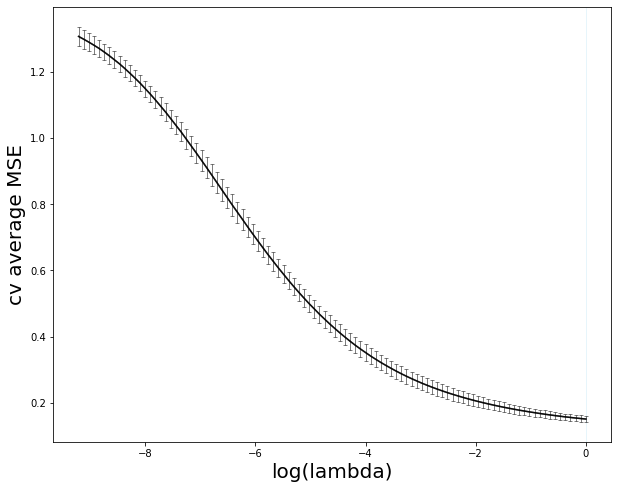

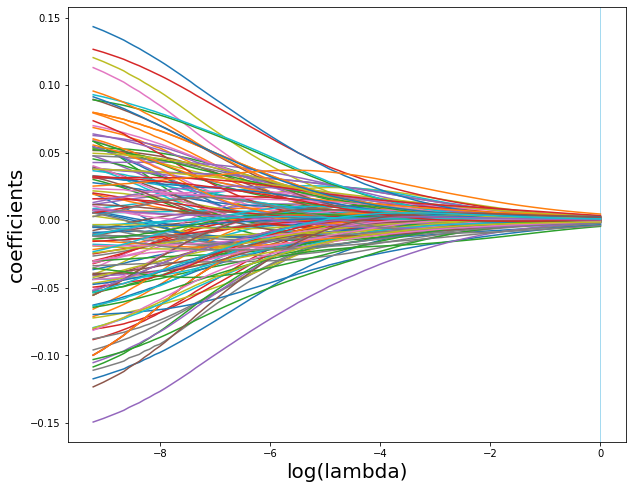

elapsed time: 0.30 minutes


In [13]:
from mbmvpa.models.regressor import elasticnet

s = time.time()
coefs = elasticnet(X, y,
                   layout,
                   n_jobs=16,
                   verbose=1,
                   max_lambda=1,
                   n_samples=5000)
task_name = 'tom2007_elasticnet'
result = get_map(coefs, voxel_mask, task_name=task_name, map_type='z', save=True, save_path='./results', sigma=1)
e = time.time()
print(f"elapsed time: {(e-s) / 60:.2f} minutes")